In [2]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd() / "notebooks"))  # so we can import _utils from notebooks/

from scipy.stats import norm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from _utils import get_data_dir

DATA_DIR = get_data_dir()
DATA_DIR


WindowsPath('C:/Users/AdamR/OneDrive/UCSB/VIU/HonorsThesis/data')

In [3]:
#Human Master Dataframe
ROOT = DATA_DIR  # assumes DATA_DIR is already defined
folders = ["50_50", "80_20", "100_0"]

from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

def df_to_pdf(df, filename):
    df = df.round(3)
    fig, ax = plt.subplots(figsize=(12, len(df)*0.4 + 1))
    ax.axis('off')
    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        loc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.2)

    with PdfPages(filename) as pdf:
        pdf.savefig(fig, bbox_inches='tight')


# Combine human CSVs from each condition folder
human_master = pd.concat(
    [pd.read_csv(ROOT / f / "human_data.csv") for f in folders],
    ignore_index=True
)

# Map condition codes
human_master["condition"] = human_master["condition"].map({
    "condition_1": "80_20",
    "condition_2": "50_50",
    "condition_3": "100_0"
})

# Keep / order desired columns
cols = [
    "stimID", "condition", "response", "side_selected", "cue_points",
    "line1_angle", "line2_angle", "valid_cue", "TP", "participantID"
]
human_master = human_master[cols]
human_master["decision"] = (human_master["response"] >= 4).astype(int)

display(human_master)


,stimID,condition,response,side_selected,cue_points,line1_angle,line2_angle,valid_cue,TP,participantID,decision
0,100,50_50,6,1,2,14.314827,1.921956,False,True,SA,1
1,845,50_50,5,1,2,15.054317,4.222230,False,True,SA,1
2,245,50_50,4,1,1,14.314827,6.508956,True,True,SA,1
3,72,50_50,4,2,2,8.775056,15.054317,True,True,SA,1
4,469,50_50,4,2,2,4.222230,19.885165,True,True,SA,1
...,...,...,...,...,...,...,...,...,...,...,...
35995,698,100_0,5,1,1,11.159944,6.508956,True,False,BC,1
35996,910,100_0,5,1,2,9.651833,4.986334,False,False,BC,1
35997,880,100_0,5,2,2,4.222230,8.775056,True,False,BC,1
35998,53,100_0,5,2,2,4.986334,11.908300,True,False,BC,1


In [4]:
#Individual human participant metrics
def sdt_metrics(g):
    n = len(g)
    tp1 = g["TP"] == 1
    tp0 = ~tp1
    resp1 = g["decision"] == 1

    hits    = (resp1 & tp1).sum()
    fas     = (resp1 & tp0).sum()
    correct = hits + ((~resp1) & tp0).sum()

    hit_rate = hits / tp1.sum()
    fa_rate  = fas  / tp0.sum()
    accuracy = correct / n

    eps_H = 1 / (2 * tp1.sum())
    eps_F = 1 / (2 * tp0.sum())
    H = min(max(hit_rate, eps_H), 1 - eps_H)
    F = min(max(fa_rate,  eps_F), 1 - eps_F)

    dprime    = norm.ppf(H) - norm.ppf(F)
    criterion = -0.5 * (norm.ppf(H) + norm.ppf(F))

    return pd.Series({
        "n_trials": n,
        "accuracy": accuracy,
        "hit_rate": hit_rate,
        "fa_rate": fa_rate,
        "dprime": dprime,
        "criterion": criterion,
    })

human_participant_metrics = (
    human_master
    .groupby(["participantID", "condition"])
    .apply(sdt_metrics)
    .reset_index()
)

human_participant_metrics.to_csv(ROOT / "human_participant_metrics.csv", index=False)
human_participant_metrics.head()



C:\Users\AdamR\AppData\Local\Temp\ipykernel_18992\515625253.py:36: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(sdt_metrics)


,participantID,condition,n_trials,accuracy,hit_rate,fa_rate,dprime,criterion
0,AG,100_0,1000.0,0.775,0.882,0.332,1.619441,-0.375323
1,AG,50_50,1000.0,0.704,0.922,0.514,1.383554,-0.726877
2,AG,80_20,1000.0,0.507,0.670,0.656,0.038342,-0.420742
3,AW,100_0,1000.0,0.657,0.744,0.430,0.832101,-0.239676
4,AW,50_50,1000.0,0.595,0.630,0.440,0.482823,-0.090442


In [5]:
#human agg table

# thresholds (easily changeable)
POS_CONF = 6  # "sure present"
NEG_CONF = 1  # "sure absent"
AVG_THRESH = 3.5  # threshold on mean confidence (1–6) for "average" aggregation

def sdt_from_binary(decisions, TPs):
    n = len(decisions)
    tp1 = TPs == 1
    tp0 = ~tp1
    resp1 = decisions == 1

    hits    = (resp1 & tp1).sum()
    fas     = (resp1 & tp0).sum()
    correct = hits + ((~resp1) & tp0).sum()

    hit_rate = hits / tp1.sum()
    fa_rate  = fas  / tp0.sum()
    accuracy = correct / n

    eps_H = 1 / (2 * tp1.sum())
    eps_F = 1 / (2 * tp0.sum())
    H = min(max(hit_rate, eps_H), 1 - eps_H)
    F = min(max(fa_rate,  eps_F), 1 - eps_F)

    dprime    = norm.ppf(H) - norm.ppf(F)
    criterion = -0.5 * (norm.ppf(H) + norm.ppf(F))
    return accuracy, hit_rate, fa_rate, dprime, criterion

rows = []

for cond, df_c in human_master.groupby("condition"):
    g = df_c.groupby("stimID")

    # Aggregate once per stimID
    agg = g.agg(
        max_resp=("response", "max"),
        min_resp=("response", "min"),
        mean_resp=("response", "mean"),     # <-- NEW: mean confidence
        mean_decision=("decision", "mean"),
        TP=("TP", "first")
    )

    # Base majority on binary decisions
    maj_decisions = (agg["mean_decision"] > 0.5).astype(int)

    # Majority with positive exception: any response >= POS_CONF → 1
    pos_excisions = np.where(agg["max_resp"] >= POS_CONF, 1, maj_decisions)

    # Majority with negative exception: any response <= NEG_CONF → 0
    neg_excisions = np.where(agg["min_resp"] <= NEG_CONF, 0, maj_decisions)

    # NEW: "average" aggregation — decision based on mean confidence
    avg_decisions = (agg["mean_resp"] >= AVG_THRESH).astype(int)

    TPs = agg["TP"].astype(bool).values

    for name, decisions in [
        ("majority", maj_decisions.values),
        ("maj_pos_exception", pos_excisions),
        ("maj_neg_exception", neg_excisions),
        ("average", avg_decisions.values),       # <-- NEW row type
    ]:
        acc, H, F, d, c = sdt_from_binary(decisions, TPs)
        rows.append({
            "aggregation": name,
            "condition": cond,
            "n_trials": len(decisions),
            "accuracy": acc,
            "hit_rate": H,
            "fa_rate": F,
            "dprime": d,
            "criterion": c,
        })

conds = human_master["condition"].unique()

def sdt_metrics(decision, TP):
    decision, TP = np.asarray(decision), np.asarray(TP)
    acc = (decision == TP).mean()
    hit = (decision[TP == 1] == 1).mean()
    fa  = (decision[TP == 0] == 1).mean()
    eps = 1e-5
    hit = np.clip(hit, eps, 1 - eps)
    fa  = np.clip(fa,  eps, 1 - eps)
    zH, zF = norm.ppf(hit), norm.ppf(fa)
    dprime = zH - zF
    c = -0.5 * (zH + zF)
    return acc, hit, fa, dprime, c

best_rows = []
for cond in conds:
    dfc = human_master[human_master["condition"] == cond]
    stats = []
    for pid, dfg in dfc.groupby("participantID"):
        stats.append((pid, *sdt_metrics(dfg["decision"], dfg["TP"])))
    pid, acc, hit, fa, dp, c = max(stats, key=lambda x: x[1])
    best_rows.append(dict(
        aggregation="best_individual",
        condition=cond,
        n_trials=len(dfc),
        accuracy=acc,
        hit_rate=hit,
        fa_rate=fa,
        dprime=dp,
        criterion=c
    ))

def wlc_for_condition(dfc):
    piv = dfc.pivot_table(index="stimID", columns="participantID", values="response")
    X = piv.values
    Xc = X - X.mean(axis=0, keepdims=True)
    trials = dfc.drop_duplicates("stimID").sort_values("stimID")
    TP = trials["TP"].values
    mu_s = Xc[TP == 1].mean(axis=0)
    mu_n = Xc[TP == 0].mean(axis=0)
    dmu = mu_s - mu_n
    Sigma = np.cov(Xc, rowvar=False)
    lam = 1e-3
    w = np.linalg.solve(Sigma + lam * np.eye(Sigma.shape[0]), dmu)
    dv = Xc @ w
    ths = np.linspace(dv.min(), dv.max(), 200)
    best_acc, best_t = -1, 0
    for t in ths:
        pred = (dv > t).astype(int)
        acc = (pred == TP).mean()
        if acc > best_acc:
            best_acc, best_t = acc, t
    pred = (dv > best_t).astype(int)
    acc, hit, fa, dp, c = sdt_metrics(pred, TP)
    return acc, hit, fa, dp, c, len(piv)

wlc_rows = []
for cond in conds:
    dfc = human_master[human_master["condition"] == cond]
    acc, hit, fa, dp, c, ntr = wlc_for_condition(dfc)
    wlc_rows.append(dict(
        aggregation="WLC",
        condition=cond,
        n_trials=ntr,
        accuracy=acc,
        hit_rate=hit,
        fa_rate=fa,
        dprime=dp,
        criterion=c
    ))

human_agg = pd.DataFrame(rows)
human_agg = pd.concat([human_agg, pd.DataFrame(best_rows + wlc_rows)], ignore_index=True)

# Order by aggregation, and within each aggregation: 100_0, 80_20, 50_50
cond_order = ["100_0", "80_20", "50_50"]
human_agg["condition"] = pd.Categorical(human_agg["condition"], categories=cond_order, ordered=True)
human_agg = human_agg.sort_values(["aggregation", "condition"]).reset_index(drop=True)

display(human_agg)

#df_to_pdf(human_agg, "outputs/human_agg_table.pdf")


,aggregation,condition,n_trials,accuracy,hit_rate,fa_rate,dprime,criterion
0,WLC,100_0,1000,0.911,0.928,0.106,2.709141,-0.106486
1,WLC,80_20,1000,0.870,0.898,0.158,2.272949,-0.133763
2,WLC,50_50,1000,0.796,0.794,0.202,1.654878,0.007060
3,average,100_0,1000,0.806,0.906,0.294,1.858255,-0.387391
4,average,80_20,1000,0.678,0.832,0.476,1.022294,-0.450952
5,average,50_50,1000,0.680,0.778,0.418,0.972469,-0.279222
6,best_individual,100_0,12000,0.874,0.870,0.122,2.291438,0.019328
7,best_individual,80_20,12000,0.703,0.640,0.234,1.084196,0.183639
8,best_individual,50_50,12000,0.704,0.922,0.514,1.383554,-0.726877
9,maj_neg_exception,100_0,1000,0.647,0.398,0.104,1.000557,0.758806


In [7]:
#Print WLC weights per participant per condition

def compute_w_for_condition(dfc):
    piv = dfc.pivot_table(index="stimID", columns="participantID", values="response")
    X = piv.values
    Xc = X - X.mean(axis=0, keepdims=True)

    # Ground truth aligned with pivot
    trials = dfc.drop_duplicates("stimID").sort_values("stimID")
    TP = trials["TP"].values

    # Means for present vs absent
    mu_s = Xc[TP == 1].mean(axis=0)
    mu_n = Xc[TP == 0].mean(axis=0)
    dmu = mu_s - mu_n

    # Covariance across participants (P x P)
    Sigma = np.cov(Xc, rowvar=False)
    lam = 1e-3

    # Solve for W
    w = np.linalg.solve(Sigma + lam * np.eye(Sigma.shape[0]), dmu)

    # Return weights and participant labels in the correct order
    participant_ids = piv.columns.tolist()
    return participant_ids, w


# Loop through conditions and print weights
for cond in sorted(human_master["condition"].unique()):
    dfc = human_master[human_master["condition"] == cond]
    participant_ids, w = compute_w_for_condition(dfc)

    print(f"\n===== WLC Weights for Condition {cond} =====")
    for pid, weight in zip(participant_ids, w):
        print(f"Participant {pid}: weight = {weight:.4f}")



===== WLC Weights for Condition 100_0 =====
Participant AG: weight = 0.1767
Participant AW: weight = -0.0299
Participant AZ: weight = -0.0088
Participant BC: weight = -0.1118
Participant CY: weight = -0.0571
Participant GS: weight = -0.0241
Participant HG: weight = 0.0399
Participant JH: weight = 0.1224
Participant KM: weight = 0.2880
Participant KZ: weight = -0.2417
Participant SA: weight = 0.0247
Participant UR: weight = 0.6247

===== WLC Weights for Condition 50_50 =====
Participant AG: weight = 0.3906
Participant AW: weight = 0.1167
Participant AZ: weight = 0.0276
Participant BC: weight = -0.1026
Participant CY: weight = -0.2056
Participant GS: weight = 0.0855
Participant HG: weight = 0.0119
Participant JH: weight = 0.4512
Participant KM: weight = 0.2704
Participant KZ: weight = 0.0124
Participant SA: weight = 0.1631
Participant UR: weight = -0.0444

===== WLC Weights for Condition 80_20 =====
Participant AG: weight = -0.1557
Participant AW: weight = 0.0029
Participant AZ: weight 

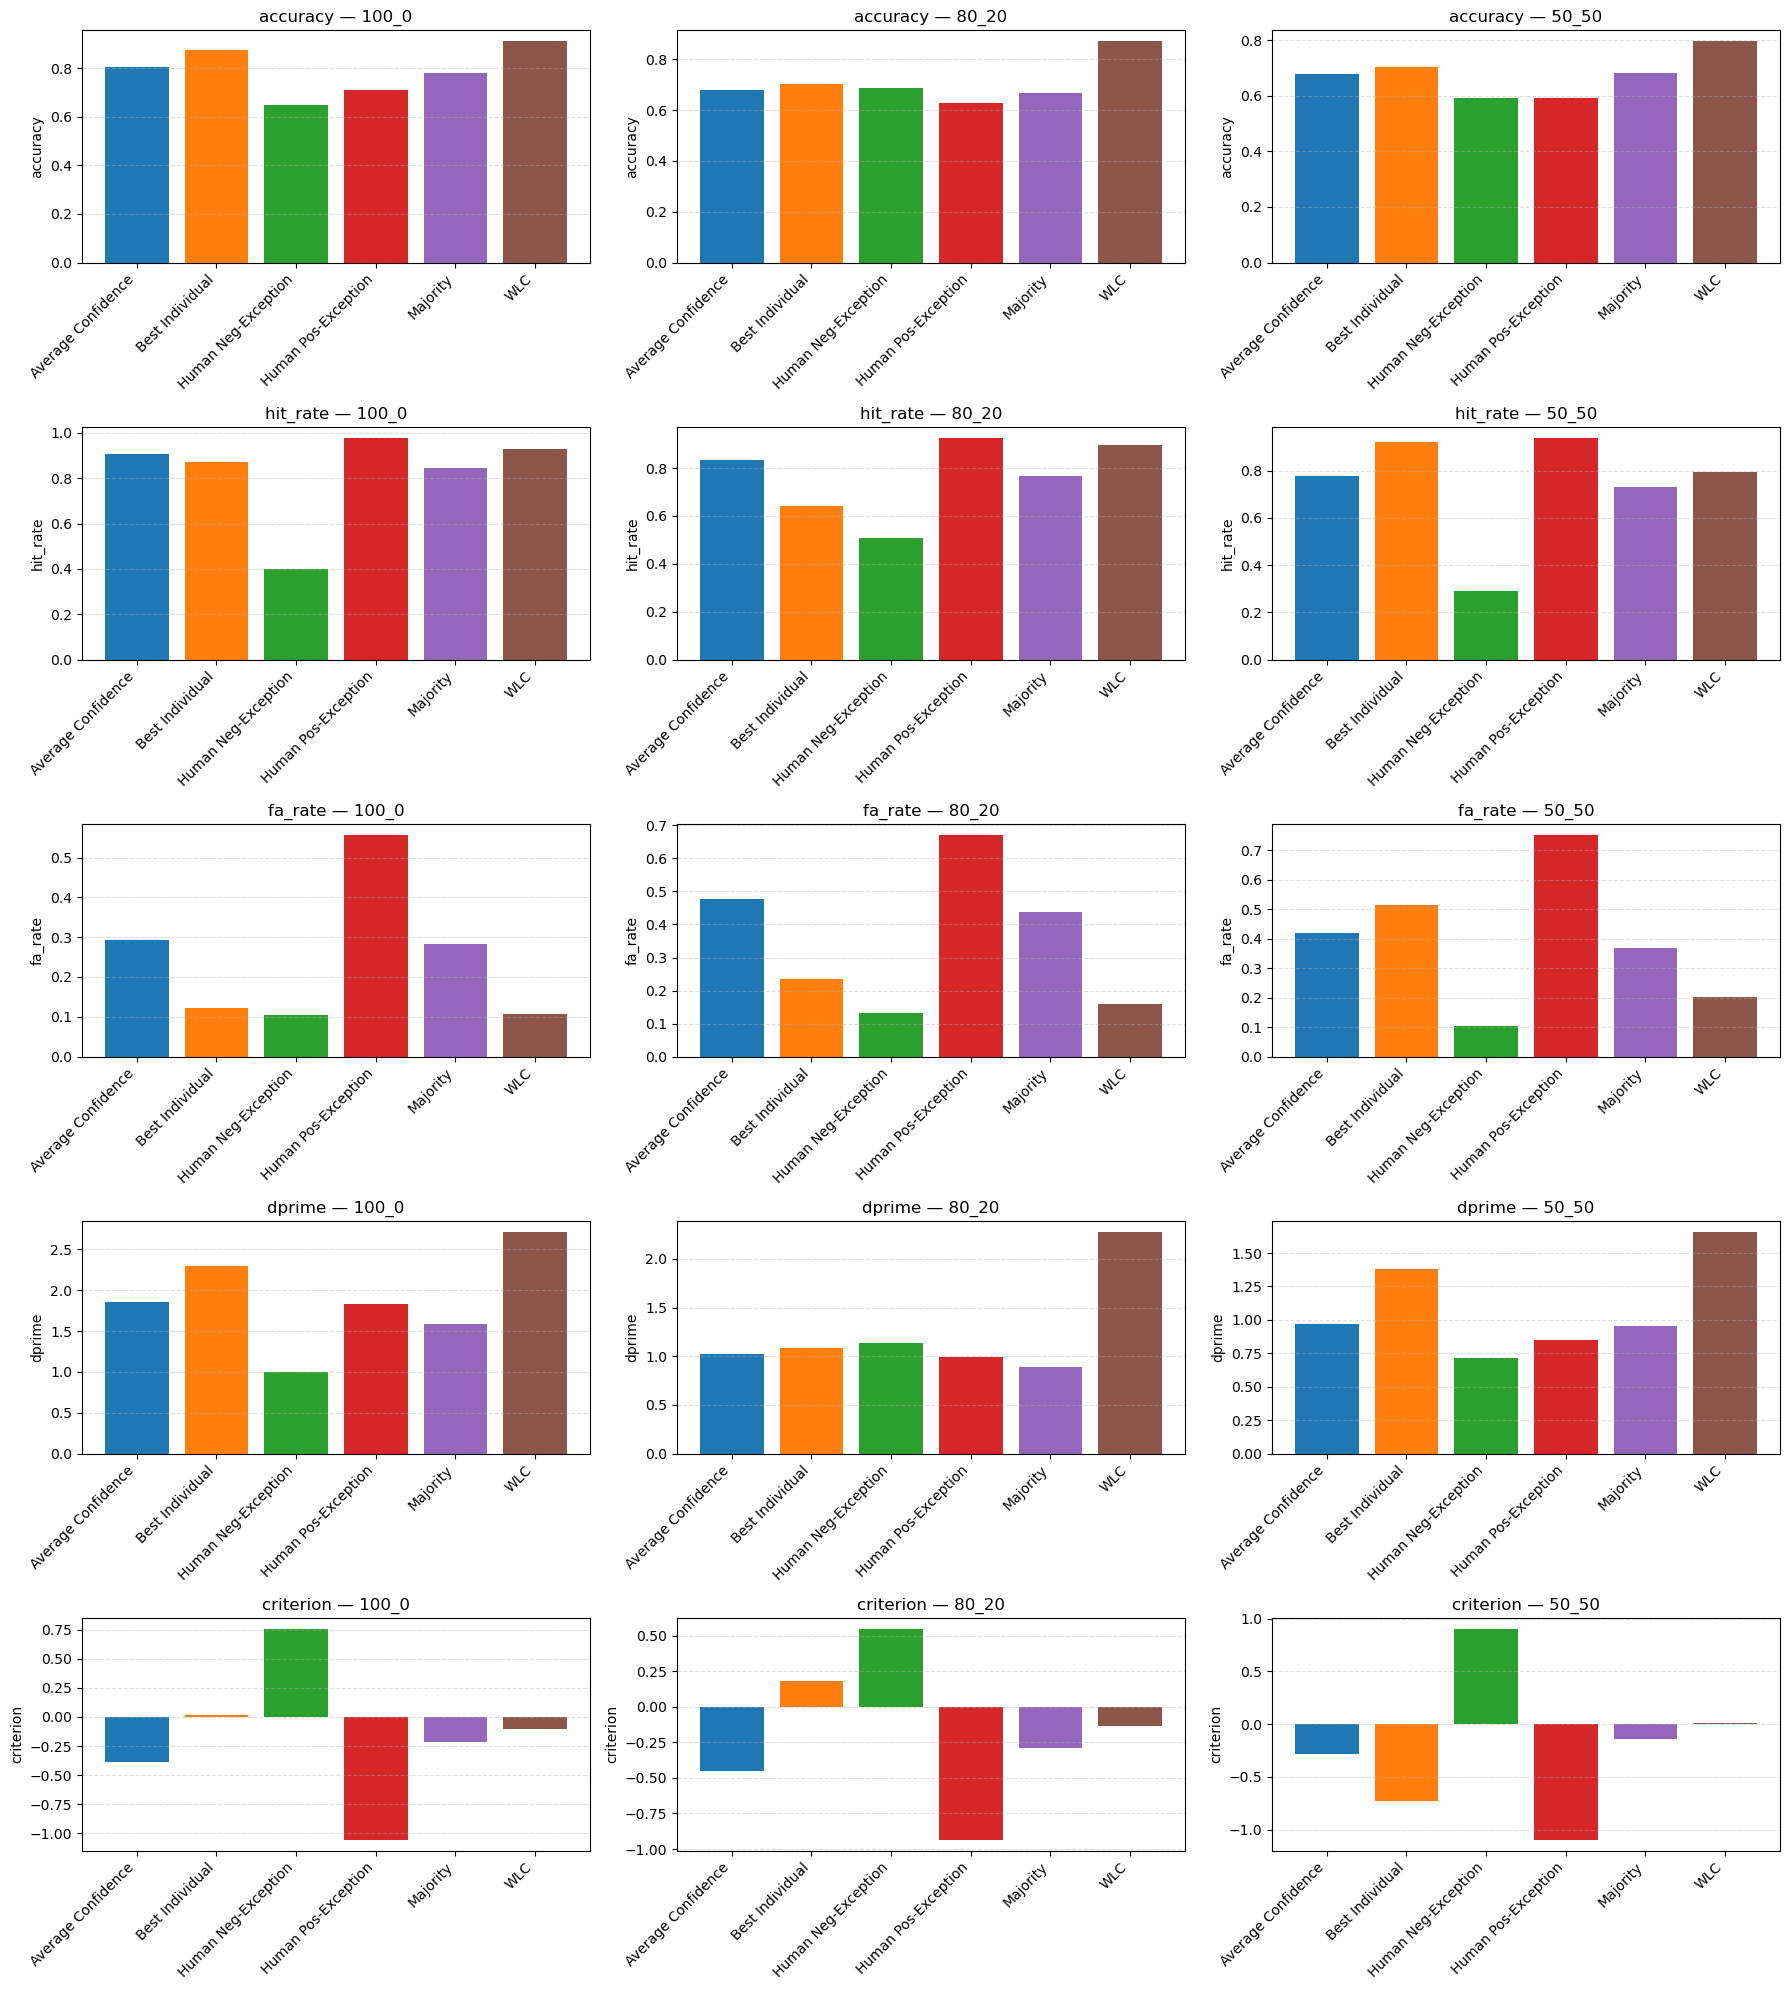

In [8]:
# Human Aggregation Plots
hag = human_agg.copy()

# Prettier aggregation labels for humans
agg_name_map_h = {
    "majority": "Majority",
    "maj_pos_exception": "Human Pos-Exception",
    "maj_neg_exception": "Human Neg-Exception",
    "average": "Average Confidence",
    "best_individual": "Best Individual",
    "WLC": "WLC",
}
hag["agg_label"] = hag["aggregation"].map(agg_name_map_h).fillna(hag["aggregation"])

# --------------------------
# Metrics & fixed condition ordering
# --------------------------
metrics = ["accuracy", "hit_rate", "fa_rate", "dprime", "criterion"]
conds = ["100_0", "80_20", "50_50"]

# Fixed aggregation ordering (based on labels)
aggs_sorted_h = sorted(hag["agg_label"].unique())

# Consistent colors per aggregation
colors_h = {a: plt.cm.tab10(i % 10) for i, a in enumerate(aggs_sorted_h)}

# --------------------------
# Create subplot grid
# --------------------------
fig, axes = plt.subplots(
    len(metrics), len(conds),
    figsize=(6 * len(conds), 4 * len(metrics)),
    sharey=False
)

# Ensure axes is 2D
if len(conds) == 1:
    axes = np.array([axes]).reshape(len(metrics), 1)

# --------------------------
# Plotting loop
# --------------------------
for i, metric in enumerate(metrics):
    for j, cond in enumerate(conds):
        ax = axes[i, j]
        
        # Filter this condition
        sub = hag[hag["condition"] == cond].copy()
        
        # Align to fixed aggregation ordering
        sub = sub.set_index("agg_label").reindex(aggs_sorted_h).reset_index()
        
        x = np.arange(len(sub))
        
        ax.bar(
            x,
            sub[metric],
            color=[colors_h[a] for a in sub["agg_label"]]
        )

        ax.set_xticks(x)
        ax.set_xticklabels(sub["agg_label"], rotation=45, ha="right")

        ax.set_title(f"{metric} — {cond}", fontsize=12)
        ax.set_ylabel(metric)
        ax.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()

# ---------- SAVE TO MULTI-PAGE PDF (OPTION 3) ----------
output_path = r"C:\Users\AdamR\Projects\Flexible-Wisdom\outputs\human_aggregation_plots_ALL.pdf"

with PdfPages(output_path) as pdf:
    pdf.savefig(fig, bbox_inches="tight")  # save this figure as 1 page

# Now show on screen
plt.show()
